In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

# use of metrics from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("/Users/gaurav/Downloads/ct_rr.csv")

In [ ]:
# see the shape of the dataset
df.shape

In [4]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


### Basic preprocessing

In [5]:
# 1. Check for any null values
df.isnull().values.any()

False

In [7]:
# So no null values are present in the dataset

In [8]:
# 2. Check for any duplicate values
df[df.duplicated()].shape

(65698, 6)

In [ ]:
# drop the duplicates from the dataset, keeping the first non-duplicate
# value

In [9]:
df.drop_duplicates(keep='first', inplace=True)

In [10]:
# shape of df after dropping the duplicates
df.shape

(8315858, 6)

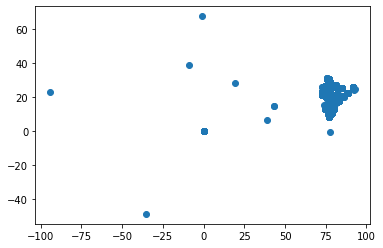

In [11]:
# Analysis of the pickup latitude and longitude
plt.scatter(x=df["pick_lng"], y=df["pick_lat"])
plt.show()

In [12]:
# Few points seems like to be outliers, rest of them form
# the shape of India, probably can drop the extremes

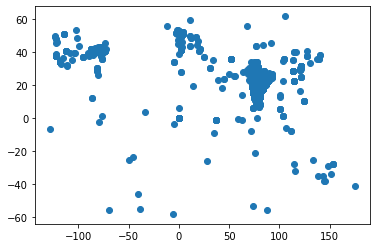

In [13]:
# Analysis of drop latitude and longitude
plt.scatter(x=df["drop_lng"], y=df["drop_lat"])
plt.show()

In [14]:
# Got India's minimum and maximum longitudes
# from https://en.wikipedia.org/wiki/Geography_of_India
min_lat, max_lat = 8.4, 37.6
min_lng, max_lng = 68.7, 97.25

In [15]:
# data-points with either pickup-point of drop-point out of India
df_out_india = df[(df["drop_lat"] < min_lat) | (df["drop_lat"] > max_lat)
               | (df["drop_lng"] < min_lng) | (df["drop_lng"] > max_lng)
               | (df["pick_lat"] < min_lat) | (df["pick_lat"] > max_lat)
               | (df["pick_lng"] < min_lng) | (df["pick_lng"] > max_lng)]

In [16]:
df_out_india.shape

(2407, 6)

In [ ]:
# 2407 rows out of 8381556 rows, we can probably drop them.

In [17]:
df.drop(df_out_india.index, inplace=True)

In [18]:
df.shape

(8313451, 6)

In [19]:
# Unique number of customers
df["number"].nunique()

170385

In [20]:
# Its a pretty big value for the number of customers, we can
# probably drop the 'number' column

In [27]:
df.drop(columns=["number"], inplace=True)

In [28]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950


In [34]:
new = df["ts"].str.split(" ", n=1, expand=True)

df["raw_date"] = new[0]
df["raw_time"] = new[1]

new = df["raw_date"].str.split("-", n=2, expand=True)
df["year"] = new[0]
df["month"] = new[1]
df["date"] = new[2]

In [35]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time,year,month,date
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17,2018,04,07
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27,2018,04,07
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44,2018,04,07
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00,2018,04,07
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29,2018,04,07


In [36]:
new = df["raw_time"].str.split(":", n=2, expand=True)
df["hour"] = new[0]
df["minute"] = new[1]
# no need to use the seconds?

In [37]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time,year,month,date,hour,minute
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17,2018,04,07,07,07
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27,2018,04,07,07,32
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44,2018,04,07,07,36
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00,2018,04,07,07,38
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29,2018,04,07,07,39


In [38]:
# drop the 'raw_date' and 'raw_time' columns
df.drop(columns=["raw_date", "raw_time"], inplace=True)

In [39]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,year,month,date,hour,minute
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018,04,07,07,07
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018,04,07,07,32
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018,04,07,07,36
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018,04,07,07,38
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018,04,07,07,39


### Experiments

In [40]:
day_df = pd.Series(df.groupby(["ts"]).size())

In [41]:
day_df

ts
2018-04-07 01:23:31    1
2018-04-07 01:27:20    1
2018-04-07 01:27:26    1
2018-04-07 01:27:29    1
2018-04-07 01:27:35    1
                      ..
2019-04-07 23:59:37    1
2019-04-07 23:59:39    1
2019-04-07 23:59:46    1
2019-04-07 23:59:53    1
2019-04-07 23:59:59    2
Length: 5888507, dtype: int64

In [43]:
df.groupby(["ts"])

In [45]:
?df.groupby

In [46]:
pd.Series(df.groupby(["ts"]).size())

ts
2018-04-07 01:23:31    1
2018-04-07 01:27:20    1
2018-04-07 01:27:26    1
2018-04-07 01:27:29    1
2018-04-07 01:27:35    1
                      ..
2019-04-07 23:59:37    1
2019-04-07 23:59:39    1
2019-04-07 23:59:46    1
2019-04-07 23:59:53    1
2019-04-07 23:59:59    2
Length: 5888507, dtype: int64

In [47]:
def create_day_series(df):
    day_df = pd.Series(df.groupby(["ts"]).size())
    day_df.index = pd.DatetimeIndex(day_df.index)
    day_df = day_df.resample("1D").apply(np.sum)
    
    return day_df

day_df = create_day_series(df)
day_df.head()

ts
2018-04-07     9328
2018-04-08     5686
2018-04-09    11496
2018-04-10    11100
2018-04-11    12041
Freq: D, dtype: int64

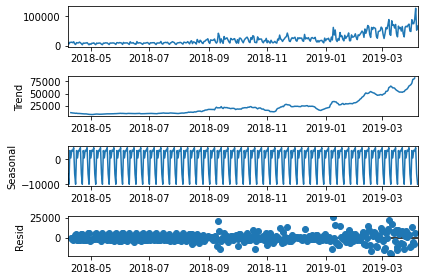

In [48]:
## Trend and Seasonality analysis
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(day_df, model='additive', freq=7)

result.plot()
plt.show()

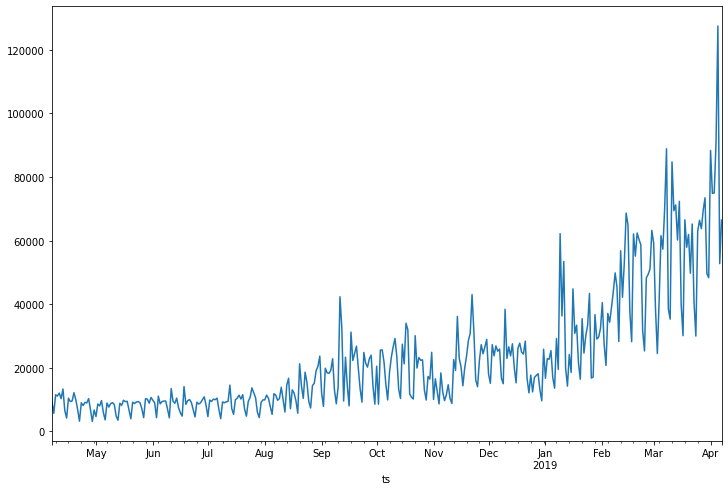

In [51]:
plt.figure(figsize=(12, 8))
day_df.plot()
plt.show()

In [55]:
type(day_df)

pandas.core.series.Series

In [53]:
day_df.index.shape

(366,)

In [56]:
Df = pd.DataFrame()
Df['ds'] = day_df.index
Df['y'] = day_df.values

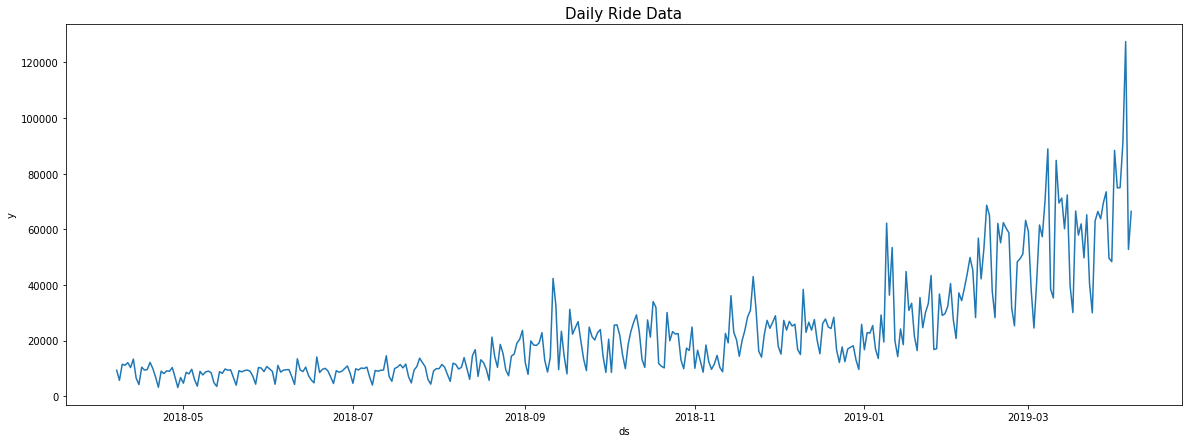

In [57]:
fig, ax = plt.subplots(figsize=(20, 7))
a = sns.lineplot(x="ds", y="y", data=Df)
a.set_title("Daily Ride Data", fontsize=15)
plt.show()

In [58]:
from fbprophet import Prophet
model = Prophet()
model.fit(Df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
train = Df.drop(Df.index[:-60])
train.shape

(60, 2)

In [60]:
train.head()

,ds,y
306,2019-02-07,43988
307,2019-02-08,49853
308,2019-02-09,45342
309,2019-02-10,28255
310,2019-02-11,56818


In [61]:
train['ds'] = pd.to_datetime(train['ds'])

In [62]:
train.head()

,ds,y
306,2019-02-07,43988
307,2019-02-08,49853
308,2019-02-09,45342
309,2019-02-10,28255
310,2019-02-11,56818


In [63]:
forecast = model.predict(train)

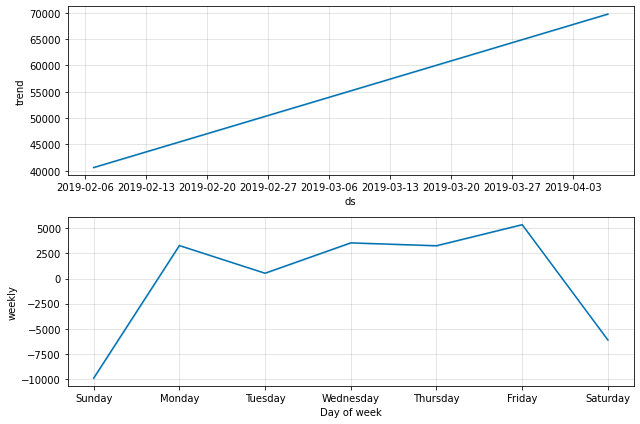

In [66]:
fig = model.plot_components(forecast)
plt.show()

In [67]:
day_df.shape

(366,)

In [68]:
Df = pd.DataFrame()

In [70]:
Df['ds'] = day_df.index
Df['y'] = day_df.values

In [71]:
Df.index[:-60]

RangeIndex(start=0, stop=306, step=1)

In [80]:
train = Df.drop(Df.index[:-60])

In [81]:
train.shape

(60, 2)

In [82]:
train.head()

,ds,y
306,2019-02-07,43988
307,2019-02-08,49853
308,2019-02-09,45342
309,2019-02-10,28255
310,2019-02-11,56818


In [83]:
train['ds'] = pd.to_datetime(train['ds'])

In [86]:
train.head()

,ds,y
306,2019-02-07,43988
307,2019-02-08,49853
308,2019-02-09,45342
309,2019-02-10,28255
310,2019-02-11,56818


In [87]:
forecast = model.predict(train)

In [88]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-07,40620.165948,34363.673481,52858.285433,40620.165948,40620.165948,3272.995001,3272.995001,3272.995001,3272.995001,3272.995001,3272.995001,0.0,0.0,0.0,43893.160949
1,2019-02-08,41114.054214,36517.649305,56419.073461,41114.054214,41114.054214,5371.388608,5371.388608,5371.388608,5371.388608,5371.388608,5371.388608,0.0,0.0,0.0,46485.442822
2,2019-02-09,41607.942479,26316.228058,46293.399518,41607.942479,41607.942479,-6116.227643,-6116.227643,-6116.227643,-6116.227643,-6116.227643,-6116.227643,0.0,0.0,0.0,35491.714837
3,2019-02-10,42101.830745,22549.428138,41683.713179,42101.830745,42101.830745,-9915.756385,-9915.756385,-9915.756385,-9915.756385,-9915.756385,-9915.756385,0.0,0.0,0.0,32186.074359
4,2019-02-11,42595.719010,35504.097669,55984.982883,42595.719010,42595.719010,3291.725769,3291.725769,3291.725769,3291.725769,3291.725769,3291.725769,0.0,0.0,0.0,45887.444780
5,2019-02-12,43089.607276,34092.411850,52843.863853,43089.607276,43089.607276,536.316206,536.316206,536.316206,536.316206,536.316206,536.316206,0.0,0.0,0.0,43625.923482
6,2019-02-13,43583.495542,37809.230988,56457.581960,43583.495542,43583.495542,3559.558444,3559.558444,3559.558444,3559.558444,3559.558444,3559.558444,0.0,0.0,0.0,47143.053985
7,2019-02-14,44077.383807,37795.873127,56213.808231,44077.383807,44077.383807,3272.995001,3272.995001,3272.995001,3272.995001,3272.995001,3272.995001,0.0,0.0,0.0,47350.378808
8,2019-02-15,44571.272073,40586.156544,59876.042209,44571.272073,44571.272073,5371.388608,5371.388608,5371.388608,5371.388608,5371.388608,5371.388608,0.0,0.0,0.0,49942.660681
9,2019-02-16,45065.160338,30278.980430,48888.970430,45065.160338,45065.160338,-6116.227643,-6116.227643,-6116.227643,-6116.227643,-6116.227643,-6116.227643,0.0,0.0,0.0,38948.932696


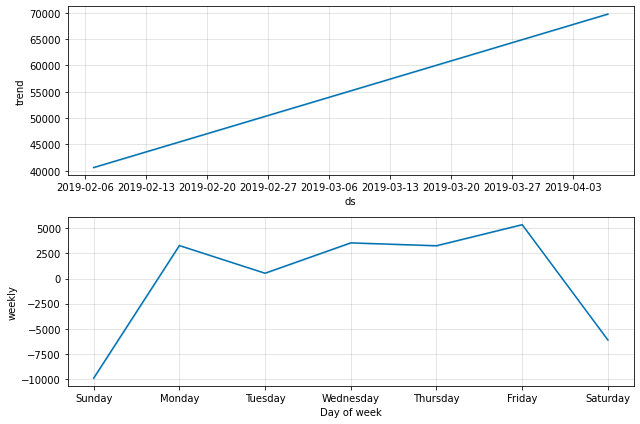

In [89]:
fig = model.plot_components(forecast)
plt.show()

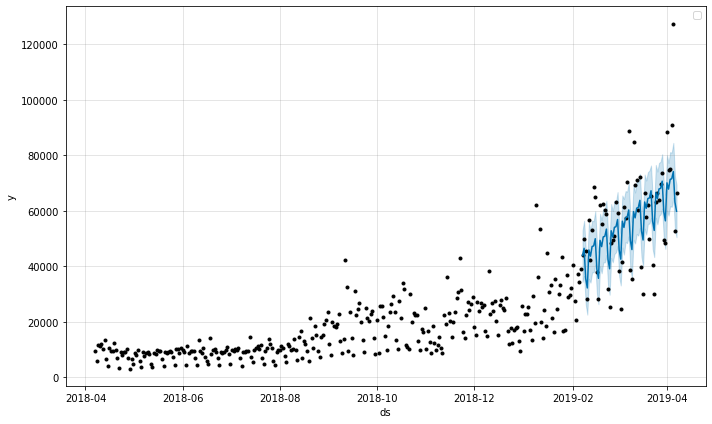

In [90]:
model.plot(forecast)
plt.legend(loc='best')
plt.show()

In [92]:
day_df.shape

(366,)

In [93]:
day_df.head()

ts
2018-04-07     9328
2018-04-08     5686
2018-04-09    11496
2018-04-10    11100
2018-04-11    12041
Freq: D, dtype: int64

In [94]:
from random import randrangege

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [96]:
result = seasonal_decompose(day_df, model='additive', freq=7)

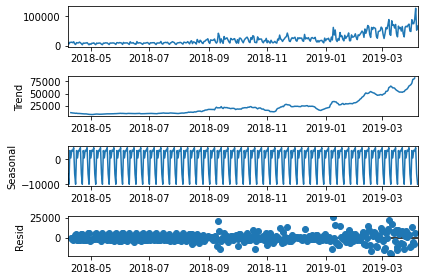

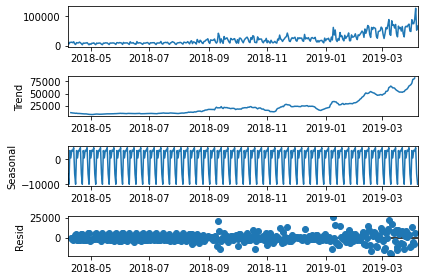

In [97]:
result.plot()

In [98]:
plt.show()

In [99]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [100]:
train, test = day_df.iloc[:300], day_df.iloc[300:]

In [101]:
model = ExponentialSmoothing(day_df, seasonal='add',
                             seasonal_periods=7).fit()

In [102]:
pred = model.predict(start=test.index[0], end=test.index[-1])

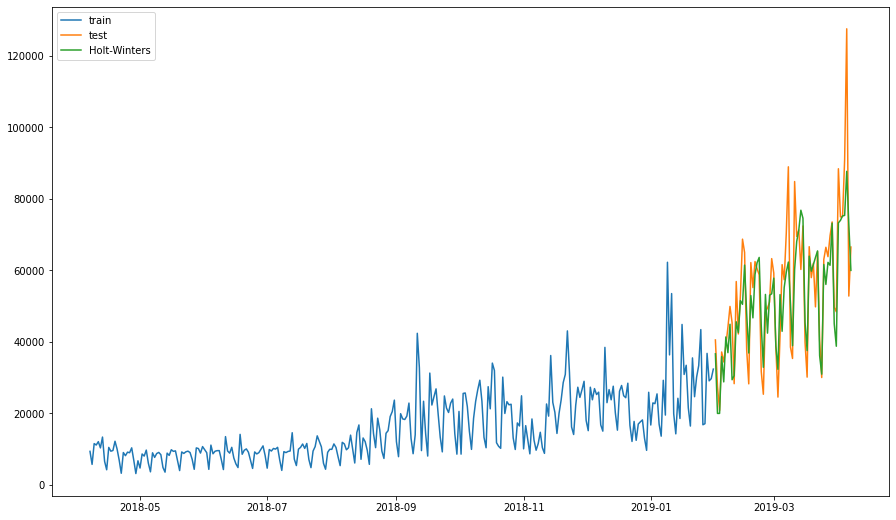

In [105]:
plt.figure(figsize=(15, 9))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')
plt.show()

In [106]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [107]:
mae = mean_absolute_error(test, pred)

In [108]:
mae

7410.784426899511

In [109]:
mape = mean_absolute_percentage_error(test, pred)

In [110]:
mape

13.957749085165785

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

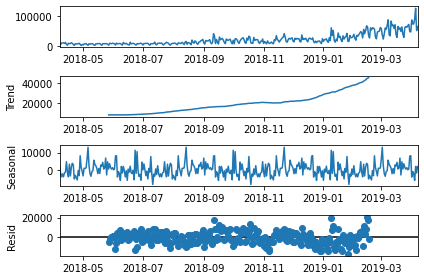

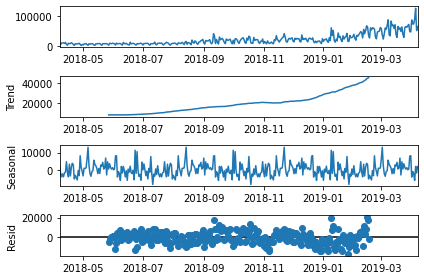

In [115]:
result = seasonal_decompose(day_df, model='additive', period=100)
result.plot()

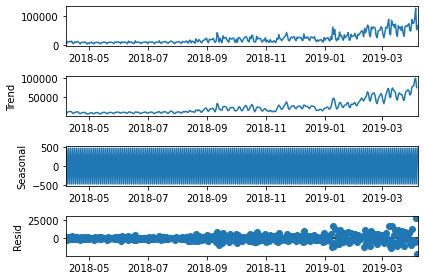

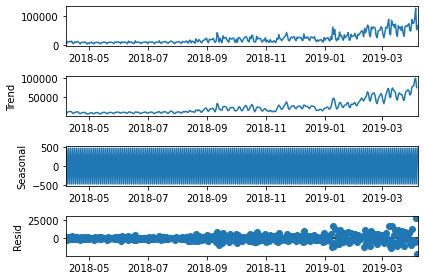

In [117]:
result = seasonal_decompose(day_df, model='additive', period=2)
result.plot()

In [118]:
?seasonal_decompose

In [120]:
?ExponentialSmoothing